<a href="https://colab.research.google.com/github/hygo2025/cdd-projeto-final/blob/main/trabalho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
# Install java
!apt install openjdk-21-jdk

In [ ]:
!sudo add-apt-repository ppa:ubuntu-toolchain-r/test
!sudo apt-get update
!sudo apt-get install --only-upgrade libstdc++6

In [6]:
%%capture
!wget "https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.4/hadoop-aws-3.3.4.jar" -P "spark/lib-jars/"
!wget "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.699/aws-java-sdk-bundle-1.12.699.jar" -P "spark/lib-jars/"
!wget "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk/1.12.699/aws-java-sdk-1.12.699.jar" -P "spark/lib-jars/"
!wget "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-core/1.12.699/aws-java-sdk-core-1.12.699.jar" -P "spark/lib-jars/"
!wget "https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-s3/1.12.699/aws-java-sdk-s3-1.12.699.jar" -P "spark/lib-jars/"

In [7]:
!java --version

openjdk 21.0.6 2025-01-21
OpenJDK Runtime Environment (build 21.0.6+7-Ubuntu-122.04.1)
OpenJDK 64-Bit Server VM (build 21.0.6+7-Ubuntu-122.04.1, mixed mode, sharing)


In [67]:
try:  # When on Google Colab, clone the repository to download any necessary cache.
    import google.colab
    repo_path = 'cdd'
    !git -C $repo_path pull origin || git clone https://github.com/hygo2025/cdd-projeto-final.git $repo_path
except:
    repo_path = '.'  # Use the local path if not on Google Colab

Already up to date.


In [ ]:
# %%capture
!pip install -r cdd/requirements.txt

In [ ]:
# %%capture
import pkg_resources
!pip install -e $repo_path

In [8]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-21-openjdk-amd64"

os.environ["SPARK_DRIVER_EXTRACLASSPATH"] = "/content/spark/lib-jars/*"
os.environ["SPARK_EXECUTOR_EXTRACLASSPATH"] = "/content/spark/lib-jars/*"
os.environ["SPARK_SERIALIZER"] = "org.apache.spark.serializer.KryoSerializer"
os.environ["ENV"] = "dev"
os.environ["PYTHONUNBUFFERED"] = "1"
os.environ["SPARK_EXECUTOR_MEMORY"] = "8g"
os.environ["SPARK_DRIVER_MEMORY"] = "8g"
os.environ["SPARK_MEMORY_FRACTION"] = "0.8"


os.environ["DOWNLOAD_FOLDER"] = "/content/datasets"

In [9]:
%load_ext autoreload
%autoreload 2

In [54]:
try:  # When on Google Colab, clone the repository to download any necessary cache.
    import google.colab
    repo_path = 'cdd'
    !git -C $repo_path pull origin || git clone https://github.com/hygo2025/cdd-projeto-final.git $repo_path
except:
    repo_path = '.'  # Use the local path if not on Google Colab

remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6 (delta 3), reused 6 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (6/6), 1.33 KiB | 1.33 MiB/s, done.
From https://github.com/hygo2025/cdd-projeto-final
   dea895b..c1d5455  main       -> origin/main
Updating dea895b..c1d5455
Fast-forward
 evaluation_result/03_sar_ncf_bivae.csv | 23 +++++++++++++++++++++++
 src/fastai_model.py                    |  3 ++-
 2 files changed, 25 insertions(+), 1 deletion(-)
 create mode 100644 evaluation_result/03_sar_ncf_bivae.csv


In [11]:
import sys
import os
import pkg_resources

if repo_path not in sys.path:
    sys.path.append(repo_path)

<ipython-input-11-2976d76b266d>:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [12]:
import cdd

In [13]:
import pandas as pd
full_results = pd.DataFrame()

In [20]:
import os
import pandas as pd

def load_or_run(full_results, filename, func, *args, **kwargs):

    if os.path.exists(filename):
        print("Arquivo já existe. Carregando dados do CSV...")
        result = pd.read_csv(filename)
        full_results = pd.concat([full_results, result], ignore_index=True)
    else:
        print("Arquivo não encontrado. Executando a função informada...")
        result = func(*args, **kwargs)
        full_results = pd.concat([full_results, result], ignore_index=True)
        full_results.to_csv(filename, index=False)
        print("Arquivo criado e salvo.")

    return full_results, result

In [15]:
import pandas as pd
from src.sar_model import SarModel
from src.utils.enums import MovieLensDataset, SimilarityType

def evaluate_sar():
    top_k = 10
    validate_size = 0.25
    time_decay_coefficient = 30
    seed = 42
    df_results = pd.DataFrame()


    # Iterando sobre todas as similaridades definidas na enumeração
    for similarity in SimilarityType:
        print(f"\nTestando similaridade: {similarity.value}")

        # Instanciando o modelo com a similaridade atual
        sar_model = SarModel(
            dataset=MovieLensDataset.ML_1M,
            top_k=top_k,
            validate_size=validate_size,
            time_decay_coefficient=time_decay_coefficient,
            similarity_type=similarity,
            seed=seed
        )

        # Avaliando o modelo
        result = sar_model.evaluate()

        result['version'] = f"similarity_{similarity.value}_top_k_{top_k}_validate_size_{validate_size}_time_decay_coefficient_{time_decay_coefficient}"
        result['algorithm'] = 'sar'

        df_results = pd.concat([df_results, result], ignore_index=True)

        print(f"Resultado para similaridade {similarity.value}:")
        print(result)
    return df_results


In [11]:
sar_results = evaluate_sar()


Testando similaridade: cooccurrence
Inicializando SarModel...
Carregando e preparando os dados...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em treino e teste com python_stratified_split...
Conjunto de treino: 750121 linhas, Conjunto de teste: 250088 linhas.
Iniciando o processo de avaliação do modelo SAR...
Iniciando o processo de predição com o modelo SAR...
Iniciando treinamento do modelo SAR...
Treinamento concluído. Salvando o modelo...
Modelo SAR treinado e salvo com sucesso.
Gerando recomendações (removendo itens já vistos)...
Juntando títulos dos itens às recomendações...
Processo de predição concluído.
Calculando métricas de avaliação (ranking)...
Avaliação concluída.
Resultado para similaridade cooccurrence:
        MAP    nDCG@K  Precision@K  Recall@K  \
0  0.173259  0.281954     0.252086  0.082533   

                                             version algorithm  
0  similarity_cooccurrence_top_k_10_validate_size..

In [21]:
full_results, sar_results = load_or_run(full_results, '01_sar.csv', evaluate_sar)

Arquivo já existe. Carregando dados do CSV...


In [22]:
full_results.head(100)

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size...,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_...,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_s...,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25...,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_t...,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_ti...,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validat...,sar


In [24]:
import itertools
import pandas as pd
from src.utils.enums import MovieLensDataset
from src.ncf_model import NcfModel

def evaluate_ncf():
    # Parâmetros a serem testados
    n_factors_options = [4]
    batch_size_options = [256, 512]
    lr_options = [1e-3]
    epochs_options = [10, 15]

    # Parâmetros fixos
    layer_sizes = [16, 8, 4]
    top_k = 10
    test_size = 0.25
    seed = 42
    dataset = MovieLensDataset.ML_1M

    # Cria um DataFrame vazio para armazenar os resultados
    df_results = pd.DataFrame()

    # Itera por todas as combinações de parâmetros
    for n_factors, batch_size, lr, epochs in itertools.product(
        n_factors_options, batch_size_options, lr_options, epochs_options
    ):
        print(f"\nTestando: n_factors={n_factors}, batch_size={batch_size}, lr={lr}, epochs={epochs}")

        # Instancia o modelo NCF com a configuração atual
        model = NcfModel(
            dataset=dataset,
            n_factors=n_factors,
            batch_size=batch_size,
            lr=lr,
            layer_sizes=layer_sizes,
            epochs=epochs,
            top_k=top_k,
            test_size=test_size,
            seed=seed
        )

        # Avalia o modelo
        result = model.evaluate()

        # Adiciona informações de identificação
        result['algorithm'] = 'ncf'
        result['version'] = f"n_factors_{n_factors}_batch_size_{batch_size}_lr_{lr}_epochs_{epochs}"

        df_results = pd.concat([df_results, result], ignore_index=True)

        print(f"Resultado: {result}")

    return df_results

In [15]:
from src.utils.utils import get_torch_device
print(get_torch_device())

2.0.1+cu117
11.7
cuda:0


In [16]:
ncf_result = evaluate_ncf()


Testando: n_factors=4, batch_size=256, lr=0.001, epochs=10
Inicializando o modelo NcfModel...
Preparando os dados com prepare_data_pandas...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dividindo os dados com python_chrono_split...
Conjunto de treino: 750121 linhas, Conjunto de teste: 250088 linhas
Filtragem dos dados concluída: o conjunto de teste contém apenas usuários e itens presentes no treino.
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Iniciando o treinamento do modelo...
Salvando arquivos temporários para os conjuntos de treino e teste...
Construindo o dataset NCF...
Construindo o modelo NCF...


/usr/local/lib/python3.11/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Treinamento concluído. Salvando o modelo...
Gerando predições para cada usuário...


Predizendo para usuários: 100%|██████████| 6040/6040 [00:14<00:00, 427.51it/s]


Construindo o DataFrame de predições...
Mesclando predições com os dados de treino para filtrar interações já conhecidas...
Processo de predição concluído.
Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.078392  0.153389     0.142881  0.054153       ncf   

                                         version  
0  n_factors_4_batch_size_256_lr_0.001_epochs_10  

Testando: n_factors=4, batch_size=256, lr=0.001, epochs=15
Inicializando o modelo NcfModel...
Preparando os dados com prepare_data_pandas...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dividindo os dados com python_chrono_split...
Conjunto de treino: 750121 linhas, Conjunto de teste: 250088 linhas
Filtragem dos dados concluída: o conjunto de teste contém apenas usuários e itens presentes no treino.
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Iniciando o treinamento do modelo...
Salvando arquivos temporários pa

/usr/local/lib/python3.11/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Treinamento concluído. Salvando o modelo...
Gerando predições para cada usuário...


Predizendo para usuários: 100%|██████████| 6040/6040 [00:14<00:00, 429.36it/s]


Construindo o DataFrame de predições...
Mesclando predições com os dados de treino para filtrar interações já conhecidas...
Processo de predição concluído.
Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:        MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.07721  0.151951     0.140993  0.054514       ncf   

                                         version  
0  n_factors_4_batch_size_256_lr_0.001_epochs_15  

Testando: n_factors=4, batch_size=512, lr=0.001, epochs=10
Inicializando o modelo NcfModel...
Preparando os dados com prepare_data_pandas...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dividindo os dados com python_chrono_split...
Conjunto de treino: 750121 linhas, Conjunto de teste: 250088 linhas
Filtragem dos dados concluída: o conjunto de teste contém apenas usuários e itens presentes no treino.
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Iniciando o treinamento do modelo...
Salvando arquivos temporários para

/usr/local/lib/python3.11/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Treinamento concluído. Salvando o modelo...
Gerando predições para cada usuário...


Predizendo para usuários: 100%|██████████| 6040/6040 [00:14<00:00, 425.38it/s]


Construindo o DataFrame de predições...
Mesclando predições com os dados de treino para filtrar interações já conhecidas...
Processo de predição concluído.
Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP   nDCG@K  Precision@K  Recall@K algorithm  \
0  0.079035  0.15329     0.142748  0.054536       ncf   

                                         version  
0  n_factors_4_batch_size_512_lr_0.001_epochs_10  

Testando: n_factors=4, batch_size=512, lr=0.001, epochs=15
Inicializando o modelo NcfModel...
Preparando os dados com prepare_data_pandas...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dividindo os dados com python_chrono_split...
Conjunto de treino: 750121 linhas, Conjunto de teste: 250088 linhas
Filtragem dos dados concluída: o conjunto de teste contém apenas usuários e itens presentes no treino.
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Iniciando o treinamento do modelo...
Salvando arquivos temporários para

/usr/local/lib/python3.11/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Treinamento concluído. Salvando o modelo...
Gerando predições para cada usuário...


Predizendo para usuários: 100%|██████████| 6040/6040 [00:14<00:00, 431.27it/s]


Construindo o DataFrame de predições...
Mesclando predições com os dados de treino para filtrar interações já conhecidas...
Processo de predição concluído.
Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.079693  0.154868     0.144586  0.055151       ncf   

                                         version  
0  n_factors_4_batch_size_512_lr_0.001_epochs_15  


In [25]:
full_results, ncf_result = load_or_run(full_results, '02_sar_ncf.csv', evaluate_ncf)

Arquivo já existe. Carregando dados do CSV...


In [18]:
full_results.head(100)

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
7,0.078392,0.153389,0.142881,0.054153,n_factors_4_batch_size_256_lr_0.001_epochs_10,ncf
8,0.077210,0.151951,0.140993,0.054514,n_factors_4_batch_size_256_lr_0.001_epochs_15,ncf
9,0.079035,0.153290,0.142748,0.054536,n_factors_4_batch_size_512_lr_0.001_epochs_10,ncf


In [26]:
!strings /usr/lib/x86_64-linux-gnu/libstdc++.so.6 | grep GLIBCXX

GLIBCXX_3.4
GLIBCXX_3.4.1
GLIBCXX_3.4.2
GLIBCXX_3.4.3
GLIBCXX_3.4.4
GLIBCXX_3.4.5
GLIBCXX_3.4.6
GLIBCXX_3.4.7
GLIBCXX_3.4.8
GLIBCXX_3.4.9
GLIBCXX_3.4.10
GLIBCXX_3.4.11
GLIBCXX_3.4.12
GLIBCXX_3.4.13
GLIBCXX_3.4.14
GLIBCXX_3.4.15
GLIBCXX_3.4.16
GLIBCXX_3.4.17
GLIBCXX_3.4.18
GLIBCXX_3.4.19
GLIBCXX_3.4.20
GLIBCXX_3.4.21
GLIBCXX_3.4.22
GLIBCXX_3.4.23
GLIBCXX_3.4.24
GLIBCXX_3.4.25
GLIBCXX_3.4.26
GLIBCXX_3.4.27
GLIBCXX_3.4.28
GLIBCXX_3.4.29
GLIBCXX_3.4.30
GLIBCXX_3.4.31
GLIBCXX_3.4.32
GLIBCXX_TUNABLES
GLIBCXX_DEBUG_MESSAGE_LENGTH


In [27]:
!pip show cornac

Name: cornac
Version: 2.3.0
Summary: A Comparative Framework for Multimodal Recommender Systems
Home-page: https://cornac.preferred.ai
Author: 
Author-email: 
License: 
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, powerlaw, scipy, tqdm
Required-by: cdd, recommenders


In [28]:
import sys
import torch
import cornac

print(f"System version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Cornac version: {cornac.__version__}")


System version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version: 2.0.1+cu117
Cornac version: 2.3.0


In [35]:
full_results

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
7,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
8,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
9,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar


In [37]:
import itertools
import pandas as pd
from src.utils.enums import MovieLensDataset
from src.bivae_model import BivaeModel

def evaluate_bivae():
    # Parâmetros a serem testados
    latent_dim_options = [50, 100]
    epochs_options = [300, 500]
    lr_options = [0.001]

    # Parâmetros fixos
    top_k = 10
    batch_size = 1024
    encoder_dims = [100]
    act_func = 'tanh'
    likelihood = 'pois'
    test_size = 0.25
    seed = 42
    dataset = MovieLensDataset.ML_1M

    # Cria um DataFrame vazio para armazenar os resultados
    df_results = pd.DataFrame()

    # Itera por todas as combinações de parâmetros
    for latent_dim, epochs, lr in itertools.product(
        latent_dim_options, epochs_options, lr_options
    ):
        print(f"\nTestando: latent_dim={latent_dim}, epochs={epochs}, lr={lr}")

        # Instancia o modelo BivaeModel com a configuração atual
        model = BivaeModel(
            dataset=dataset,
            top_k=top_k,
            batch_size=batch_size,
            latent_dim=latent_dim,
            encoder_dims=encoder_dims,
            act_func=act_func,
            likelihood=likelihood,
            epochs=epochs,
            lr=lr,
            test_size=test_size,
            seed=seed
        )

        # Avalia o modelo
        result = model.evaluate()

        # Adiciona informações de identificação
        result['algorithm'] = 'bivae'
        result['version'] = f"latent_dim_{latent_dim}_epochs_{epochs}_lr_{lr}"


        df_results = pd.concat([df_results, result], ignore_index=True)

        print(f"Resultado: {result}")

    return df_results


In [38]:
full_results, bivae_result = load_or_run(full_results, '03_sar_ncf_bivae.csv', evaluate_bivae)


Arquivo não encontrado. Executando a função informada...

Testando: latent_dim=50, epochs=300, lr=0.001
/content/datasets
ML_1M
/content/datasets
ML_1M
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Number of users: 6040
Number of items: 3669


  0%|          | 0/300 [00:00<?, ?it/s]

Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.259884  0.389566      0.35894  0.128636     bivae   

                             version  
0  latent_dim_50_epochs_300_lr_0.001  

Testando: latent_dim=50, epochs=500, lr=0.001
/content/datasets
ML_1M
/content/datasets
ML_1M
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Number of users: 6040
Number of items: 3669


  0%|          | 0/500 [00:00<?, ?it/s]

Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.278428  0.410565     0.376242  0.136264     bivae   

                             version  
0  latent_dim_50_epochs_500_lr_0.001  

Testando: latent_dim=100, epochs=300, lr=0.001
/content/datasets
ML_1M
/content/datasets
ML_1M
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Number of users: 6040
Number of items: 3669


  0%|          | 0/300 [00:00<?, ?it/s]

Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP   nDCG@K  Precision@K  Recall@K algorithm  \
0  0.252058  0.38164     0.351209   0.12416     bivae   

                              version  
0  latent_dim_100_epochs_300_lr_0.001  

Testando: latent_dim=100, epochs=500, lr=0.001
/content/datasets
ML_1M
/content/datasets
ML_1M
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Number of users: 6040
Number of items: 3669


  0%|          | 0/500 [00:00<?, ?it/s]

Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.271206  0.405428     0.373179  0.137093     bivae   

                              version  
0  latent_dim_100_epochs_500_lr_0.001  
Arquivo criado e salvo.


In [39]:
full_results.head(100)

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
7,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
8,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
9,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar


In [40]:
import itertools
import pandas as pd
from src.utils.enums import MovieLensDataset
from src.light_gcn_model import LightGcnModel

def evaluate_lightgcn():
    # Parâmetros a serem testados
    n_layers_options = [2, 3, 4]
    lr_options = [0.005, 0.01]
    epochs_options = [1, 5]

    # Parâmetros fixos
    batch_size = 1024
    top_k = 10
    test_size = 0.2
    seed = 42
    dataset = MovieLensDataset.ML_1M

    # Cria um DataFrame vazio para armazenar os resultados
    df_results = pd.DataFrame()

    # Itera por todas as combinações de parâmetros
    for n_layers, lr, epochs in itertools.product(n_layers_options, lr_options, epochs_options):
        print(f"\nTestando: n_layers={n_layers}, lr={lr}, epochs={epochs}")

        # Instancia o modelo LightGcnModel com a configuração atual
        model = LightGcnModel(
            dataset=dataset,
            n_layers=n_layers,
            batch_size=batch_size,
            lr=lr,
            epochs=epochs,
            top_k=top_k,
            test_size=test_size,
            seed=seed
        )

        # Avalia o modelo
        result = model.evaluate()

        # Adiciona informações de identificação
        result['algorithm'] = 'lightgcn'
        result['version'] = f"n_layers_{n_layers}_lr_{lr}_epochs_{epochs}"

        df_results = pd.concat([df_results, result], ignore_index=True)

        print(f"Resultado: {result}")

    return df_results


In [49]:
!mkdir -p resource
!cp cdd/src/resource/lightgcn.yaml resource/

In [50]:
full_results, lightgcn_result = load_or_run(full_results, '04_sar_ncf_bivae_lightgcn.csv', evaluate_lightgcn)


Arquivo não encontrado. Executando a função informada...

Testando: n_layers=2, lr=0.005, epochs=1
/content/datasets
ML_1M
/content/datasets
ML_1M
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Iniciando o modelo...
Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Treinando o modelo...
Epoch 1 (train)11.1s: train loss = 0.33165 = (mf)0.33107 + (embed)0.00058
Modelo treinado.
Calculando métricas de avaliação (top K)...
Avaliação concluída.
Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.140427  0.239946     0.215215   0.08398  lightgcn   

                        version  
0  n_layers_2_lr_0.005_epochs_1  

Testando: n_layers=2, lr=0.005, epochs=5
/content/datasets
ML_1M
/content/datasets
ML_1M
Iniciando o processo de avaliação...
Iniciando o processo de predição...
Iniciando o modelo...
Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Tre

In [51]:
full_results.head(100)

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
7,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
8,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
9,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar


In [57]:
import itertools
import pandas as pd
from src.utils.enums import MovieLensDataset
from src.fastai_model import FastAiModel

def evaluate_fastai():
    # Parâmetros a serem testados
    n_factors_options = [40]
    epochs_options = [15]

    # Parâmetros fixos
    test_size = 0.25
    top_k = 10
    seed = 42
    dataset = MovieLensDataset.ML_1M

    # Cria um DataFrame vazio para armazenar os resultados
    df_results = pd.DataFrame()

    # Itera por todas as combinações de parâmetros
    for n_factors, epochs in itertools.product(n_factors_options, epochs_options):
        print(f"\nTestando: n_factors={n_factors}, epochs={epochs}")

        # Instancia o modelo FastAiModel com a configuração atual
        model = FastAiModel(
            dataset=dataset,
            n_factors=n_factors,
            test_size=test_size,
            epochs=epochs,
            top_k=top_k,
            seed=seed
        )

        # Avalia o modelo
        result = model.evaluate()

        # Adiciona informações de identificação
        result['algorithm'] = 'fastai'
        result['version'] = f"n_factors_{n_factors}_epochs_{epochs}"

        df_results = pd.concat([df_results, result], ignore_index=True)

        print(f"Resultado: {result}")

    return df_results


In [58]:
full_results, fastai_result = load_or_run(full_results, '05_sar_ncf_bivae_lightgcn_fastai.csv', evaluate_fastai)


Arquivo não encontrado. Executando a função informada...

Testando: n_factors=40, epochs=15
Inicializando o modelo FastAiModel...
Preparando os dados com prepare_data_pandas...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dividindo os dados em treino e teste...
Conjunto de treino: 750156 linhas; Conjunto de teste: 250053 linhas.
Filtrando o conjunto de teste para incluir apenas usuários presentes no treino...
Inicialização concluída.

Iniciando avaliação do modelo FastAi...
Iniciando processo de predição...
Configurando sementes para reprodutibilidade...
Sementes configuradas.

Carregando o modelo treinado...
Iniciando treinamento do modelo FastAi...
Configurando sementes para reprodutibilidade...
Sementes configuradas.

Criando DataLoaders de colaboração a partir do conjunto de treino...
Criando o learner do modelo de colaboração...
Iniciando o ciclo de treinamento...


epoch,train_loss,valid_loss,time
0,0.855573,None,00:56
1,0.868685,None,00:56
2,0.837105,None,00:56
3,0.838536,None,00:57
4,0.850378,None,00:56
5,0.840097,None,00:56
6,0.820697,None,00:56
7,0.799747,None,00:57
8,0.774347,None,00:56
9,0.796251,None,00:56


/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/usr/local/lib/python3.11/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your 

Treinamento concluído.

Obtendo usuários e itens conhecidos pelo modelo...
Total de usuários conhecidos: 6040; Total de itens conhecidos: 3676
Filtrando usuários do conjunto de teste que estão presentes no modelo...
Número de usuários de teste filtrados: 6040
Criando produto cartesiano entre usuários válidos e itens conhecidos...
Garantindo consistência dos tipos de dados...
Removendo pares já presentes no conjunto de treino...
Total de pares para predição: 21452884
Calculando pontuações para os pares filtrados...
Predição concluída.

Convertendo tipos dos dados de predição...
Calculando métricas de avaliação (top K)...
Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm                 version
0  0.103932  0.190846     0.173675  0.056479    fastai  n_factors_40_epochs_15
Arquivo criado e salvo.


In [59]:
full_results.head(100)

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
7,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
8,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
9,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar


In [60]:
import itertools
import pandas as pd
from src.utils.enums import MovieLensDataset
from src.als_model import SparkAlsModel

def evaluate_als(spark):
    # Definindo os grids de parâmetros
    max_iter_options = [20]
    rank_options = [10, 20, 30, 40]
    reg_param_options = [0.05]
    alpha_options = [0.1]

    # Parâmetros fixos
    validate_size = 0.25
    top_k = 10
    seed = 42
    dataset = MovieLensDataset.ML_1M

    # Cria um DataFrame vazio para armazenar os resultados
    df_results = pd.DataFrame()

    # Itera por todas as combinações de parâmetros
    for max_iter, rank, reg_param, alpha in itertools.product(
            max_iter_options, rank_options, reg_param_options, alpha_options
    ):
        print(f"\nTestando: maxIter={max_iter}, rank={rank}, regParam={reg_param}, alpha={alpha}")

        # Instanciando o modelo ALS com a configuração atual
        als_model = SparkAlsModel(
            spark=spark,
            dataset=dataset,
            max_iter=max_iter,
            rank=rank,
            reg_param=reg_param,
            alpha=alpha,
            validate_size=validate_size,
            top_k=top_k,
            seed=seed
        )


        # Avaliando o modelo
        result = als_model.evaluate()

        # Adiciona as informações desejadas
        result['algorithm'] = 'als'
        result['version'] = f"max_iter_{max_iter}_rank_{rank}_reg_param_{reg_param}_alpha_{alpha}"

        df_results = pd.concat([df_results, result], ignore_index=True)
        print(f"Resultado: {result}")


    return df_results

In [64]:
from src.utils.spark_session_utils import create_spark_session

spark = create_spark_session("ALS")

full_results, als_result = load_or_run(full_results, '06_sar_ncf_bivae_lightgcn_fastai_als.csv', evaluate_als, spark)



Testando: maxIter=20, rank=10, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross join entre usuários e itens...
Gerando predições utilizando o modelo ALS...
Removendo itens já vistos (presentes no treino)...
Renomenado colunas...
Renomenado colunas...
Cacheando os DataFrames...
Iniciando join entre os DataFrames...
+---------+---

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.016286  0.043168     0.047666  0.013576       als   

                                        version  
0  max_iter_20_rank_10_reg_param_0.05_alpha_0.1  

Testando: maxIter=20, rank=20, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.029713  0.070092     0.069603  0.019971       als   

                                        version  
0  max_iter_20_rank_20_reg_param_0.05_alpha_0.1  

Testando: maxIter=20, rank=30, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.036147  0.082743     0.080017  0.023649       als   

                                        version  
0  max_iter_20_rank_30_reg_param_0.05_alpha_0.1  

Testando: maxIter=20, rank=40, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.043372  0.096373     0.091623  0.027791       als   

                                        version  
0  max_iter_20_rank_40_reg_param_0.05_alpha_0.1  
Arquivo não encontrado. Executando a função informada...

Testando: maxIter=20, rank=10, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e i

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.016286  0.043168     0.047666  0.013576       als   

                                        version  
0  max_iter_20_rank_10_reg_param_0.05_alpha_0.1  

Testando: maxIter=20, rank=20, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.029713  0.070092     0.069603  0.019971       als   

                                        version  
0  max_iter_20_rank_20_reg_param_0.05_alpha_0.1  

Testando: maxIter=20, rank=30, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.036147  0.082743     0.080017  0.023649       als   

                                        version  
0  max_iter_20_rank_30_reg_param_0.05_alpha_0.1  

Testando: maxIter=20, rank=40, regParam=0.05, alpha=0.1
Inicializando SparkAlsModel...
Carregando e preparando os dados com prepare_data_spark...
/content/datasets
ML_1M
/content/datasets
ML_1M
Dados carregados: 1000209 linhas.
Dividindo os dados em conjuntos de treino e teste...
Conjunto de treino: 750210 linhas; Conjunto de teste: 249999 linhas.
Filtrando o conjunto de teste para manter apenas usuários presentes no treino...
Após filtragem, teste possui: 249999 linhas.

Iniciando avaliação do modelo ALS...
Gerando predições para avaliação...
Iniciando predição com o modelo ALS...
Iniciando treinamento do modelo ALS...
Treinamento concluído. Salvando o modelo...
Obtendo usuários e itens distintos do conjunto de treino...
Realizando cross 

/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Avaliação concluída.

Resultado:         MAP    nDCG@K  Precision@K  Recall@K algorithm  \
0  0.043372  0.096373     0.091623  0.027791       als   

                                        version  
0  max_iter_20_rank_40_reg_param_0.05_alpha_0.1  
Arquivo criado e salvo.


In [65]:
full_results.head(100)

,MAP,nDCG@K,Precision@K,Recall@K,version,algorithm
0,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
1,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
2,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
3,0.185099,0.309862,0.279222,0.109562,similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
4,0.000000,0.000000,0.000000,0.000000,similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
5,0.000098,0.000360,0.000414,0.000183,similarity_lift_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
6,0.008060,0.018790,0.019472,0.003072,similarity_mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
7,0.173259,0.281954,0.252086,0.082533,similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
8,0.219533,0.345610,0.307864,0.114765,similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar
9,0.006920,0.020386,0.025563,0.005893,similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30,sar


        MAP    nDCG@K  Precision@K  Recall@K  \
0  0.173259  0.281954     0.252086  0.082533   
1  0.219533  0.345610     0.307864  0.114765   
2  0.006920  0.020386     0.025563  0.005893   
3  0.185099  0.309862     0.279222  0.109562   
4  0.000000  0.000000     0.000000  0.000000   

                                                                                              version  \
0                       similarity_cooccurrence_top_k_10_validate_size_0.25_time_decay_coefficient_30   
1                             similarity_cosine_top_k_10_validate_size_0.25_time_decay_coefficient_30   
2                    similarity_inclusion index_top_k_10_validate_size_0.25_time_decay_coefficient_30   
3                            similarity_jaccard_top_k_10_validate_size_0.25_time_decay_coefficient_30   
4  similarity_lexicographers mutual information_top_k_10_validate_size_0.25_time_decay_coefficient_30   

  algorithm  
0       sar  
1       sar  
2       sar  
3       sar  
4       sa

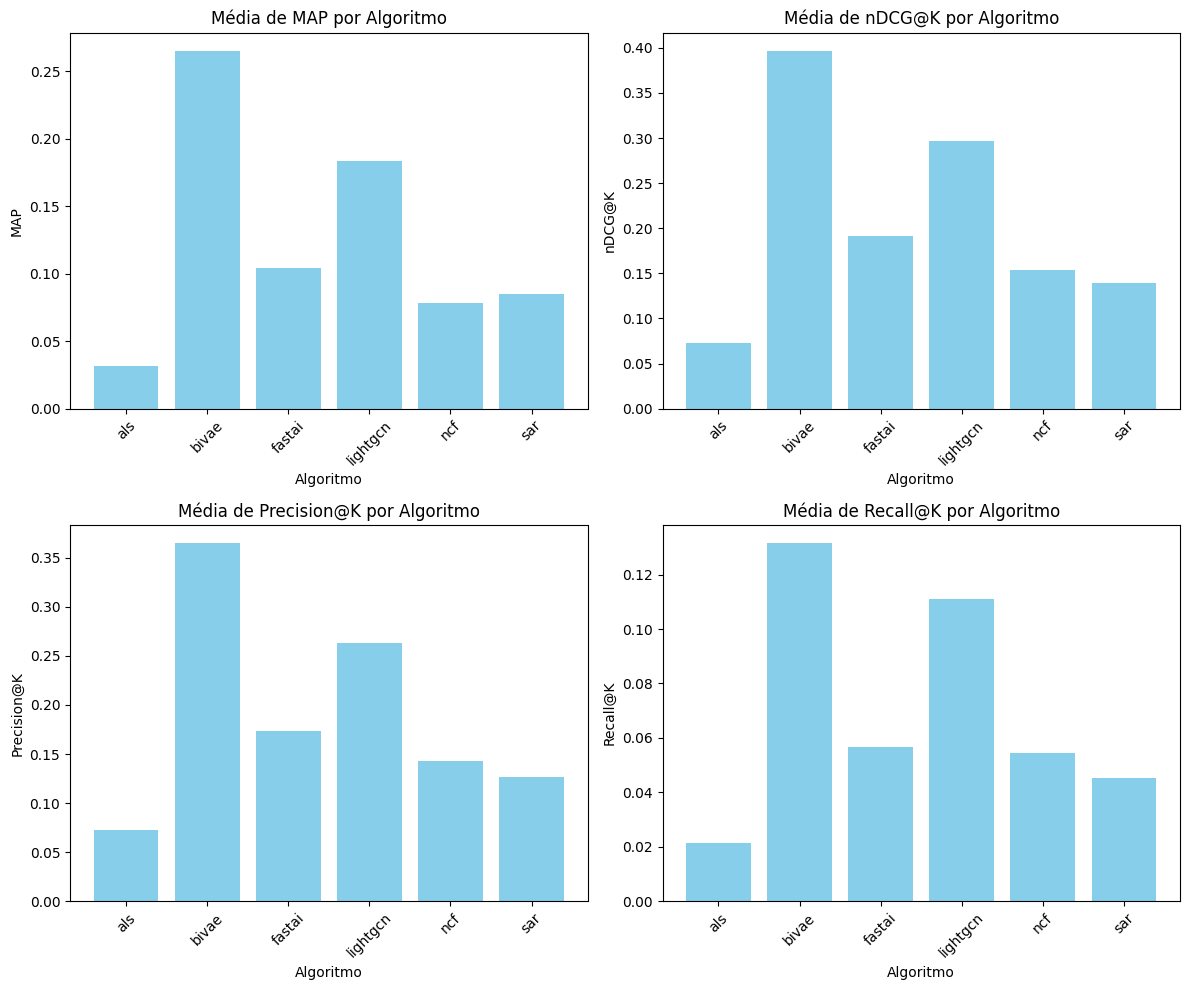

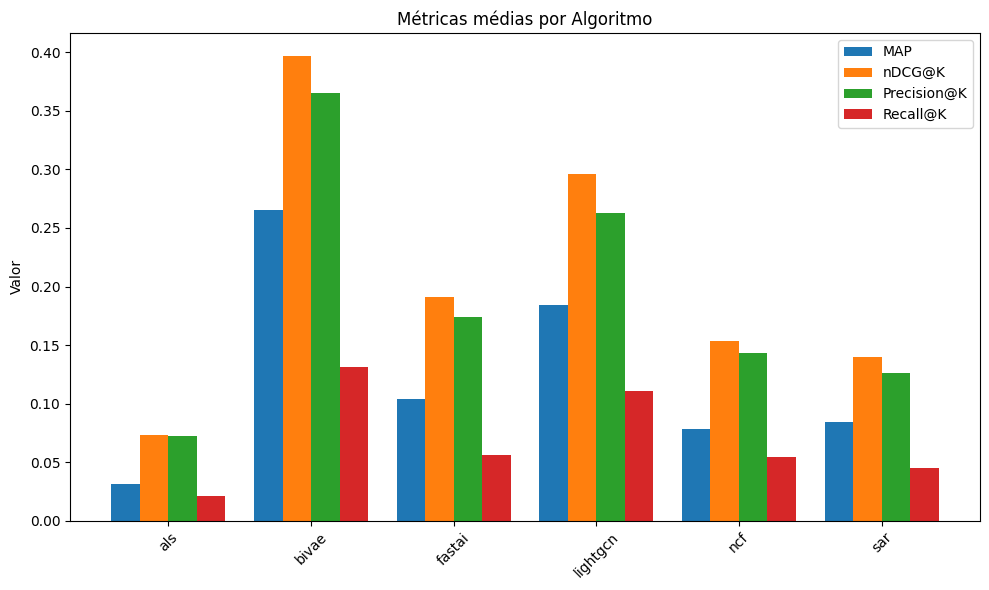

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = full_results

# Exibe as 5 primeiras linhas para conferência
print(df.head())

metrics = ['MAP', 'nDCG@K', 'Precision@K', 'Recall@K']
grouped = df.groupby('algorithm')[metrics].mean().reset_index()

fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    axs[i].bar(grouped['algorithm'], grouped[metric], color='skyblue')
    axs[i].set_title(f"Média de {metric} por Algoritmo")
    axs[i].set_xlabel("Algoritmo")
    axs[i].set_ylabel(metric)
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
x = np.arange(len(grouped['algorithm']))

# Cria uma barra para cada métrica
for i, metric in enumerate(metrics):
    ax.bar(x + i * bar_width, grouped[metric], width=bar_width, label=metric)

ax.set_xticks(x + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(grouped['algorithm'], rotation=45)
ax.set_ylabel("Valor")
ax.set_title("Métricas médias por Algoritmo")
ax.legend()
plt.tight_layout()
plt.show()
